<a href="https://colab.research.google.com/github/Raginii/Color-Concept-Associations-using-Google-Images/blob/master/AnalysisWithVaryingNumberOfImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the best model by varying the number of images used for training

In [1]:
# ## Uncomment if using Google Colab and upload file dataTop50.xlsx
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Initialize these:
filepath = 'dataTop50.xlsx'
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [0]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [0]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"
sz = 100

In [5]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

# ** Using the features obtained from best model in CorrelationsFromFeatures **

In [0]:
selFt = (54, 179, 180)

In [25]:
Xfull = np.copy(Q[:,selFt])
Yfull = np.copy(Q[:,-1])
print(Xfull.shape, Yfull.shape)
XX = np.column_stack([Xfull,Yfull])
print(XX.shape)

(34800, 3) (34800,)
(34800, 4)


In [0]:
# Function to computer average error, correlation and rating for all test fruit category 
# based on the features selected from the best model (Spherical + Cylindrical + categorical)

        
def getAvgErrCorr(startInd, X, y):
    xNew = np.column_stack([X,y])
    
    correlation = []
    error = []
    
    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    for i in range(len(startInd)-1):
        xTemp = np.copy(xNew)
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        #print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(XX[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(startInd[i],startInd[i+1]),0)
        #print(testTemp.shape, trainTemp.shape)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        #print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        #print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        #print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)

    #return np.mean(error), np.mean(correlation)    
    return error, correlation, np.mean(error), np.mean(correlation)

## Prepare the datset to include top images of every fruit -- 5,10,15,20, .. 50


In [27]:
n = [i for i in range(50,0,-5)]
n

[50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

In [0]:
avgErr = []
avgCorr = []

for i in n:
  startInd = [0]
  X = np.empty((0,3), float)
  y = np.empty((0,), float)
  if i!=50:
    for t in range(len(strtInd)-1):
      X = np.r_[X, Xfull[strtInd[t]:strtInd[t+1]-(50-i)*58,:] ]
      y = np.r_[y, Yfull[strtInd[t]:strtInd[t+1]-(50-i)*58]]
      startInd.append(len(X))
    
  else:
    startInd = [i for i in strtInd]
    X = np.copy(Xfull)
    y = np.copy(Yfull)
#   print(startInd)
#   print(X.shape)
  _, _, e,c = getAvgErrCorr(startInd,X,y)
  avgErr.append(e)
  avgCorr.append(c)
    


In [29]:
avgErr

[0.7729293303382093,
 0.7703616918660369,
 0.7714228139542149,
 0.773291106704279,
 0.7744072661832688,
 0.7701561356670759,
 0.7669042725092957,
 0.7592035805533189,
 0.7453760182442547,
 0.7347960176639763]

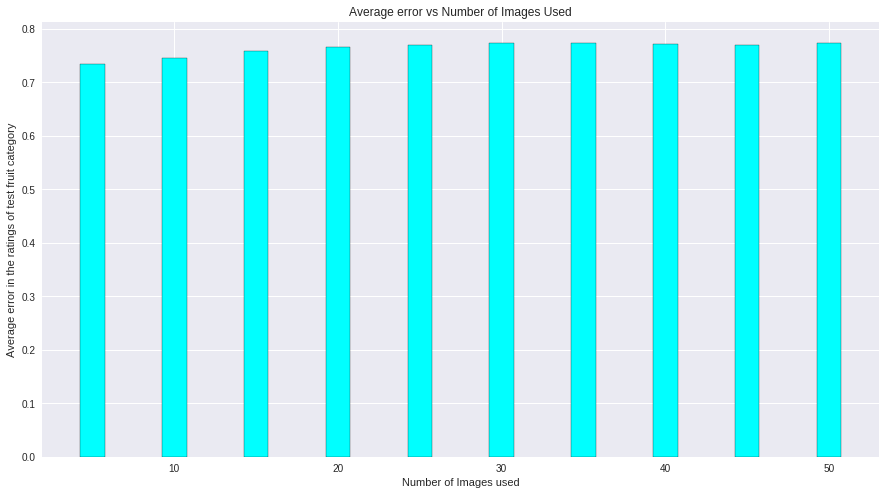

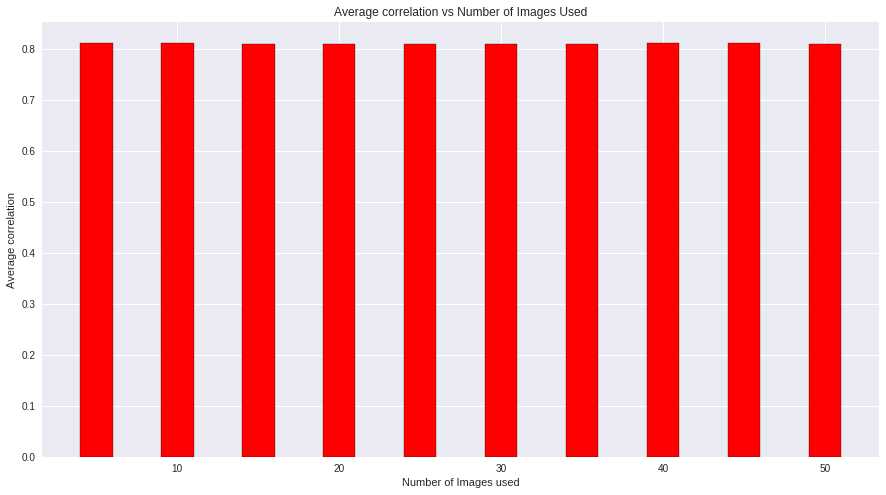

In [30]:
fig = plt.figure(figsize=(15,8))
plt.bar(n,avgErr,width = 1.5, color = 'cyan', edgecolor = 'k',label='Spherical')
plt.title("Average error vs Number of Images Used")
plt.xlabel('Number of Images used')
plt.ylabel("Average error in the ratings of test fruit category")

fig = plt.figure(figsize=(15,8))
plt.bar(n,avgCorr,width = 2, color = 'red', edgecolor = 'k')
plt.title("Average correlation vs Number of Images Used")
plt.xlabel('Number of Images used')
plt.ylabel("Average correlation")
plt.show()

In [0]:
err = []
corr = []
n2 = [5, 50]
for i in n2:
  startInd = [0]
  X = np.empty((0,3), float)
  y = np.empty((0,), float)
  if i!=50:
    for t in range(len(strtInd)-1):
      X = np.r_[X, Xfull[strtInd[t]:strtInd[t+1]-(50-i)*58,:] ]
      y = np.r_[y, Yfull[strtInd[t]:strtInd[t+1]-(50-i)*58]]
      startInd.append(len(X))
    
  else:
    startInd = [i for i in strtInd]
    X = np.copy(Xfull)
    y = np.copy(Yfull)
#   print(startInd)
#   print(X.shape)
  e,c, _,_ = getAvgErrCorr(startInd,X,y)
  err.append(e)
  corr.append(c)
    

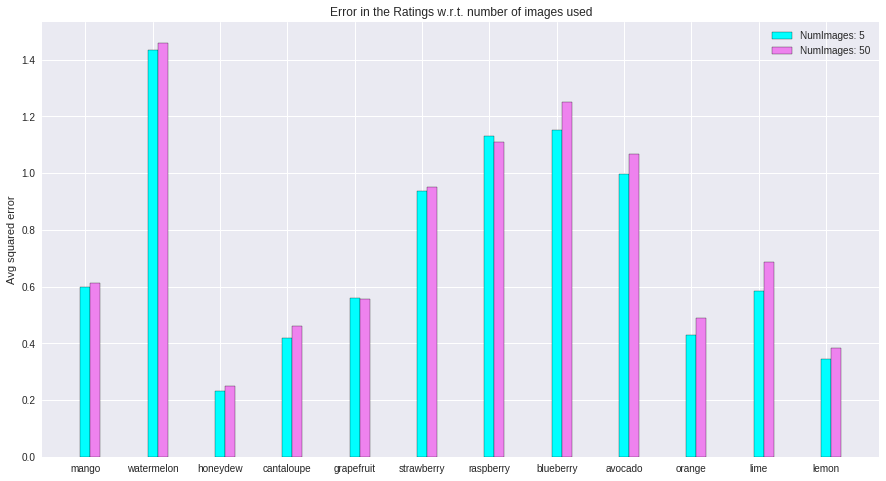

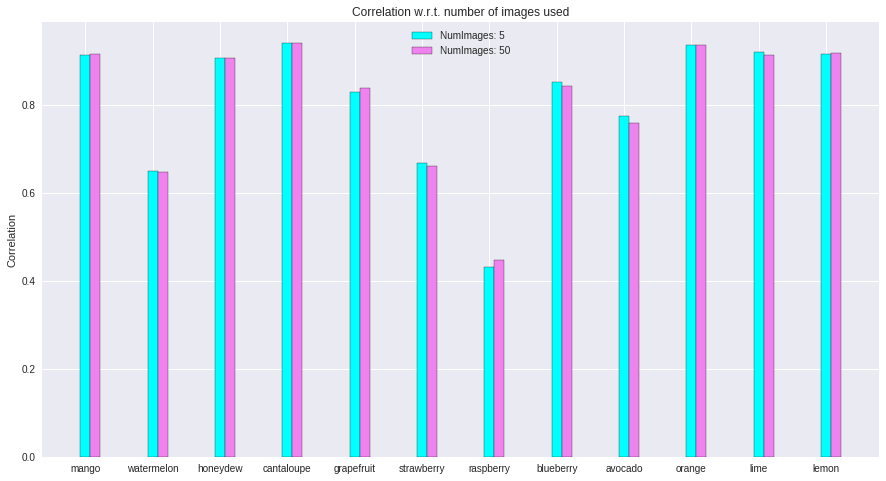

In [32]:
plt.close('all')
barWidth = 1.5
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]

fig = plt.figure(figsize=(15,8))
plt.bar(r1,err[0],width = barWidth, color = 'cyan', edgecolor = 'black',label='NumImages: 5')
plt.bar(r2,err[1],width = barWidth, color = 'violet', edgecolor = 'black',label='NumImages: 50')
plt.xticks(range(1,121,10),allConcepts)
plt.title("Error in the Ratings w.r.t. number of images used")
plt.ylabel('Avg squared error')
plt.legend()

fig = plt.figure(figsize=(15,8))
plt.bar(r1,corr[0],width = barWidth, color = 'cyan', edgecolor = 'black',label='NumImages: 5')
plt.bar(r2,corr[1],width = barWidth, color = 'violet', edgecolor = 'black',label='NumImages: 50')
plt.xticks(range(1,121,10),allConcepts)
plt.title("Correlation w.r.t. number of images used")
plt.ylabel('Correlation')
plt.legend()

plt.show()